In [186]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np

In [187]:
class KANLayer(nn.Module):
    def __init__(self, in_dim, out_dim, num_intervals, spline_order):
        super(KANLayer, self).__init__()

        self.in_dim = in_dim
        self.num_intervals = num_intervals
        self.spline_order = spline_order
        
        initial_domain = [-1, 1]
        num_control_points = num_intervals + spline_order
        variance = 0.1

        # Parameters for in_dim * out_dim activation functions
        # Initialize control points for all activations
        self.control_points = nn.Parameter(torch.as_tensor(np.random.normal(0, variance, (in_dim * out_dim, num_control_points))), requires_grad=True)

        # Initialize grid per activation function
        grid = torch.linspace(initial_domain[0], initial_domain[1], num_intervals + 1)
        step_size = (initial_domain[1] - initial_domain[0]) / num_intervals

        pre_padding = torch.linspace(initial_domain[0] - spline_order * step_size, initial_domain[0] - step_size, spline_order)
        post_padding = torch.linspace(initial_domain[1] + step_size, initial_domain[1] + spline_order * step_size, spline_order)
        extended_grid = torch.cat((pre_padding, grid, post_padding))
        self.grids = extended_grid.repeat(in_dim * out_dim, 1)

    def batched_cox_de_boor(self, i, degree, x):
        if degree == 0:
            return (self.grids[:, i] <= x) * (x < self.grids[:, i + 1])
        
        left_side = (x - self.grids[:, i]) / (self.grids[:, i + degree] - self.grids[:, i]) * self.batched_cox_de_boor(i, degree - 1, x)
        right_side = (self.grids[:, i + degree + 1] - x) / (self.grids[:, i + degree + 1] - self.grids[:, i + 1]) * self.batched_cox_de_boor(i + 1, degree - 1, x)

        return left_side + right_side
    
    def forward(self, x):
        # Compute activations
        result = 0.0
        for i in range(self.num_intervals + self.spline_order):
            result += self.control_points[:, i] * self.batched_cox_de_boor(i, self.spline_order, x)

        # Sum results over all activations if in_dim > 1
        if self.in_dim > 1:
            result = result.sum(dim=1)

        return result
    


Epoch 0, loss: 0.269482403310961
Epoch 100, loss: 0.013484359865768238
Epoch 200, loss: 0.001944843597998827
Epoch 300, loss: 0.0009721235453824393
Epoch 400, loss: 0.0004652476566101886
Epoch 500, loss: 0.0001990267875623278
Epoch 600, loss: 7.65532010940024e-05
Epoch 700, loss: 2.653553834517709e-05
Epoch 800, loss: 8.283009381098407e-06
Epoch 900, loss: 2.3214408742285767e-06


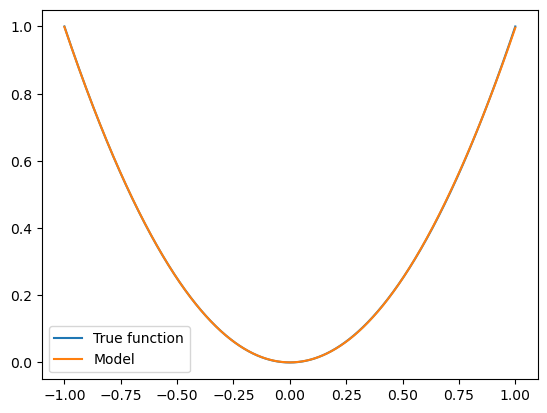

In [188]:
# 1D example
model = KANLayer(1, 1, 5, 2)

opt = torch.optim.Adam(model.parameters(), lr=0.01)

def f(x):
    return x**2

data = torch.linspace(-1, 1, 1000)
labels = f(data)

for i in range(1000):
    opt.zero_grad()

    out = model(data)
    loss = (out - labels)**2
    loss = loss.mean()
    loss.backward()
    opt.step()

    if i % 100 == 0:
        print(f"Epoch {i}, loss: {loss.item()}")

plt.plot(data, labels, label="True function")
plt.plot(data, out.detach().numpy(), label="Model")

plt.legend()
plt.show()

Epoch 0, loss: 0.9060491383220651
Epoch 100, loss: 0.04751180278749329
Epoch 200, loss: 0.0029351384057861155
Epoch 300, loss: 0.0007482618722561713
Epoch 400, loss: 0.00040038646749680773
Epoch 500, loss: 0.00020036663663405296
Epoch 600, loss: 9.179278429170778e-05
Epoch 700, loss: 3.868030979192473e-05
Epoch 800, loss: 1.5054977814879547e-05
Epoch 900, loss: 5.43169055146436e-06


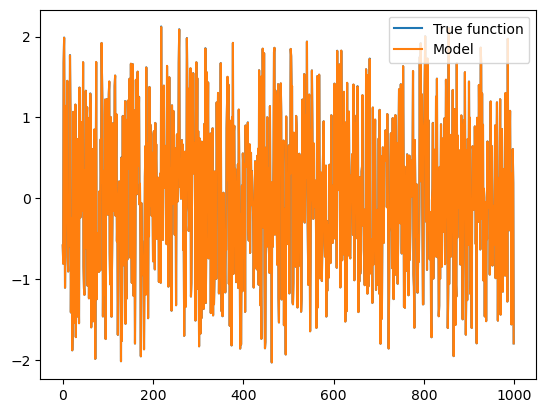

In [191]:
# 2D example
model = KANLayer(2, 1, 5, 2)

opt = torch.optim.Adam(model.parameters(), lr=0.01)

def f(x, y):
    return x + 1.2*y

data = torch.rand(1000, 2) * 2 - 1
labels = f(data[:, 0], data[:, 1])

for i in range(1000):
    opt.zero_grad()

    out = model(data)
    loss = (out - labels)**2
    loss = loss.mean()
    loss.backward()
    opt.step()

    if i % 100 == 0:
        print(f"Epoch {i}, loss: {loss.item()}")

plt.plot(labels, label="True function")
plt.plot(out.detach().numpy(), label="Model")

plt.legend()
plt.show()